# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add TRA folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/TRA")

Wall time: 0 ns


# Overview

In the following notebok we compute the TRA from AVISO data. The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'
<br />
2. Define computational parameters (such as the number of cores) and data
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data
 <br />
5. Trajectory Rotation Angle $ \mathrm{\overline{TRA}} $:
    
    * Compute velocity along trajectories $ \lbrace \mathbf{\dot{x}}(t_{i}) \rbrace_{i=0}^N $ over the time interval $ [t_0, t_N] $.
    
    * Compute $ \mathrm{\overline{TRA}} $ from velocity along trajectories:
    
    \begin{equation}
            \mathrm{\overline{TRA}}_{t_0}^{t_N} = \dfrac{1}{t_N-t_0} \sum_{i = 0}^{N-1} \cos^{-1}\dfrac{\langle \mathbf{\dot{x}}(t_i), \mathbf{\dot{x}}(t_{i+1}) \rangle+\mathrm{v}_0^2}{\sqrt{|\mathbf{\dot{x}}(t_i)|^2+\mathrm{v}_0^2}\sqrt{|\mathbf{\dot{x}}(t_{i+1})|^2+\mathrm{v}_0^2}}
    \end{equation}
    
    $ \mathrm{v}_0 $ is a characteristic velocity, which can be be estimated by taking the spatio-temporal average of the velocity over the whole dataset.

# Import Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

Wall time: 145 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 8

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

# set nan values

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 20

# time step-size (in days)
dt = .1

time = np.arange(t0, tN+dt, dt)

# length of time interval (in days)
lenT = tN-t0

# longitudinal and latitudinal boundaries (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -28

# make sure that domain is in the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"
    
# spacing of meshgrid (in degrees)
dx = 0.025
dy = 0.025

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Wall time: 998 µs


# Velocity interpolation

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant. 

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time, method = "cubic")

Wall time: 88.9 ms


# Trajectory Rotation Average ($ \mathrm{\overline{TRA}}$)

In [6]:
%%time
# Import package for computing trajectories/velocity along trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import package which checks particle location
from ipynb.fs.defs.check_location import check_location

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package for TRA
from ipynb.fs.defs.TRA import _TRA

# set v0 is equal to the average velocity in the Agulhas region
v0 = np.mean(np.sqrt(U.ravel()**2+V.ravel()**2))

import matplotlib.pyplot as plt

def parallel_TRA(i):
    
    TRA_parallel = X_domain[0,:].copy()*np.nan
    
    for j in range(X_domain.shape[1]):
        
        # set initial condition
        x = np.array([X_domain[i, j], Y_domain[i, j]])
        
        # only compute TRA for trajectories starting region where velocity field is defined
        if check_location(X, Y, defined_domain, x)[0] == "IN":

            # compute velocity along trajectory
            dFdt = integration_dFdt(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta)[1]
    
            TRA_parallel[j] = _TRA(lenT, dFdt, v0)
        
        else:
            
            TRA_parallel[j] = np.nan
        
    return TRA_parallel

TRA = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_TRA)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/161 [00:00<?, ?it/s]

Wall time: 50.7 s


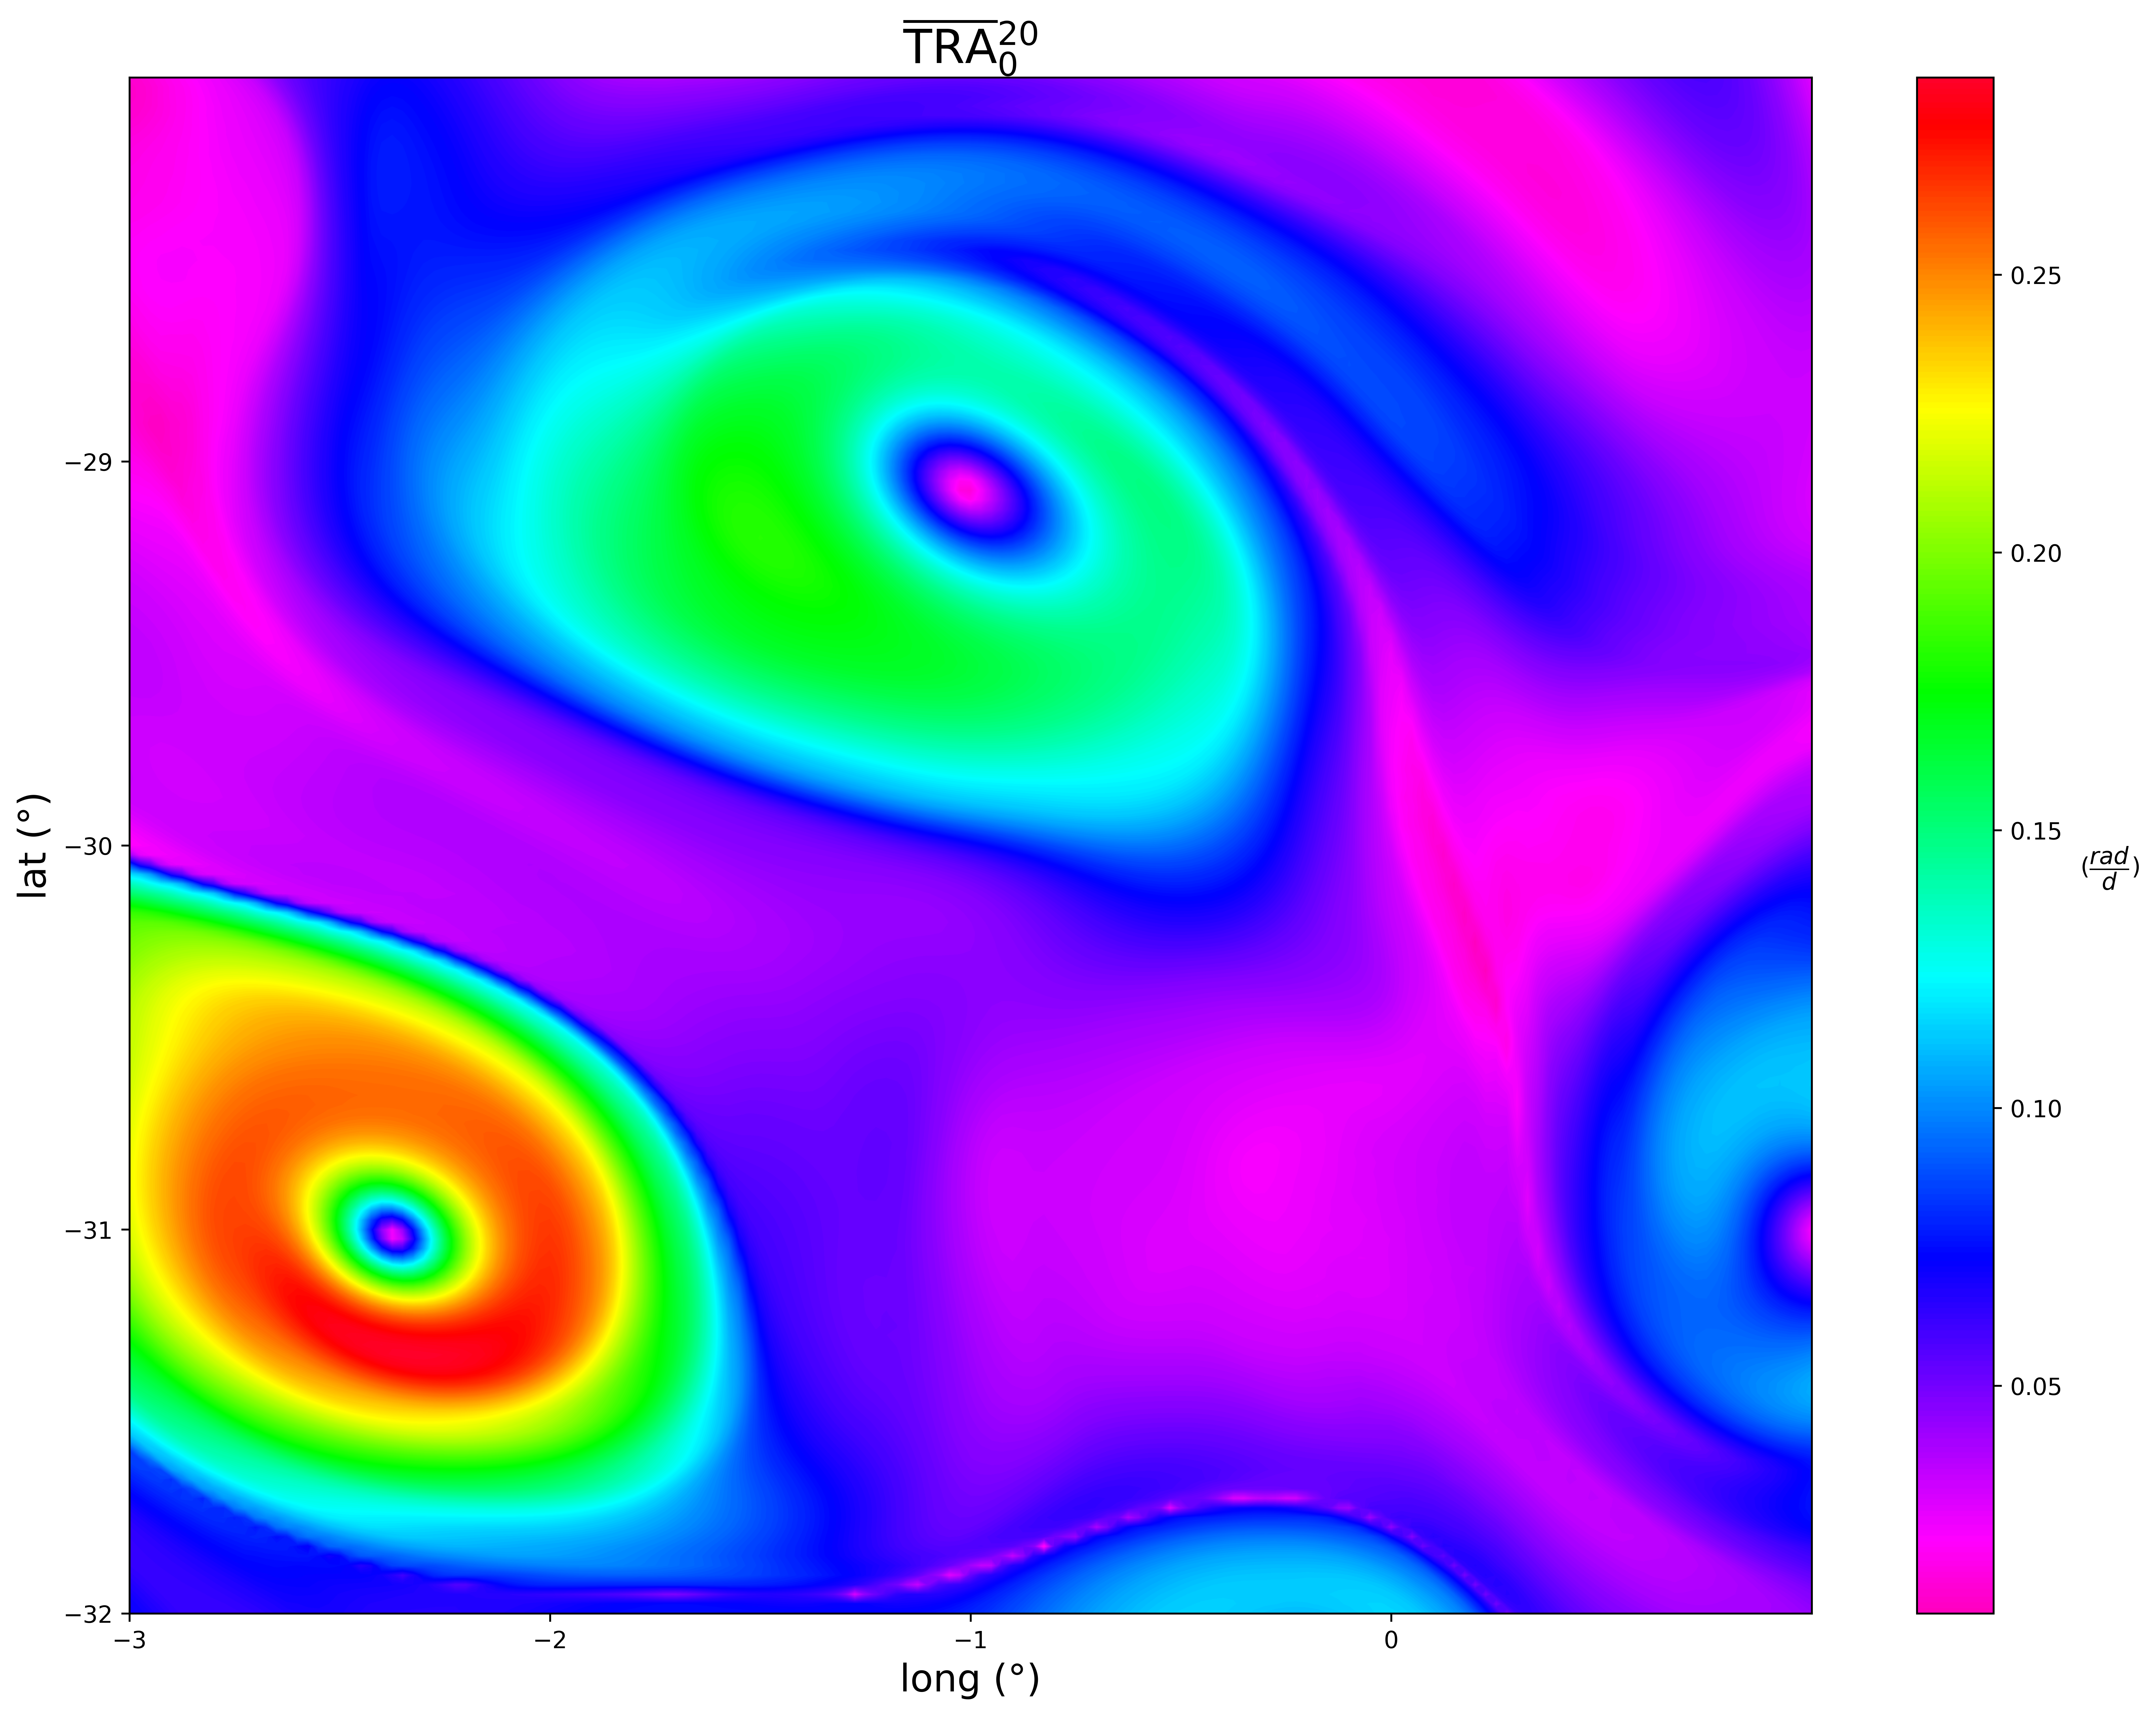

In [7]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt

# Figure/Axis
fig = plt.figure(figsize=(16, 12), dpi = 600)
ax = plt.axes()

# Contourplot of TRA over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(TRA), cmap = "gist_rainbow_r", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, 1, 21))
cbar.ax.set_ylabel(r'$(\dfrac{rad}{d})$', rotation = 0, labelpad = 20, fontsize = 10)

# Title
ax.set_title(r'$ \mathrm{\overline{TRA}}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$', fontsize = 20)

plt.show()

Regions of high $ \mathrm{\overline{TRA}}_{t_0}^{t_N} $ are linked to vortical flow features. Note that the $ \mathrm{\overline{TRA}} $ highlights the same vortical flow structures as other commonly used rotation diagnostics such as the [Polar Rotation Angle](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/PRA/Main/PRAAgulhas.ipynb) or the [EllipticLCS](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/EllipticLCS/Main/EllipticLCSAgulhas.ipynb).

# References

[1] Haller, G., Aksamit, N., & Encinas-Bartos, A. P. (2021). Quasi-objective coherent structure diagnostics from single trajectories. Chaos: An Interdisciplinary Journal of Nonlinear Science, 31(4), 043131.